In [76]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import pandas as pd
import yaml
import geopandas as gp
import time
import pandas as pd
from geopy.distance import great_circle
import folium
import h5py
from scipy.signal import butter, lfilter

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

In [77]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [78]:
flag_project = 1

if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
name_project = 'project_repartition_v4.0/output_repar_v9.5_04--10-16Hz/'

In [79]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_04--10-16Hz/


In [80]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [81]:
rdir_project_probes = info_basic['rdir_project_probes']
rdir_project_targets = info_basic['rdir_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, rdir_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, rdir_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  ./project/output_regular_v9.5_3x7/
dir_project_targets:  ./project/output_regular_v9.5_5x13/


In [82]:
name_projects = []
name_projects.append('project/output_regular_v9.5_3x7/')
name_projects.append('project/output_regular_v9.5_5x13/')
name_projects.append('project_repartition_v4.0/output_repar_v9.5_04--10-16Hz/')
name_projects.append('project_repartition_v4.0/output_repar_v9.5_05--10-16Hz/')

In [83]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

In [84]:
dir_CC = dir_CC_workspace + info_basic['rdir_CC']
dir_ds = dir_project + info_basic['rdir_ds']
dir_partition = dir_project + info_basic['rdir_partition']
dir_partition_probes = dir_project_probes + info_basic_probes['rdir_partition']
dir_partition_targets = dir_project_targets + info_basic_targets['rdir_partition']
#dir_disp_pick = dir_project + info_basic['rdir_disp_pick']
dir_disp_probes  = dir_project_probes + info_basic_probes['rdir_disp_autopick'] 
dir_image = dir_project + info_basic['rdir_image'] + 'paper_tomo_Re-srl/'
if os.path.exists(dir_image) == False:
    os.makedirs(dir_image)

In [85]:
key_subworks_all = info_basic['key_subworks']
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']

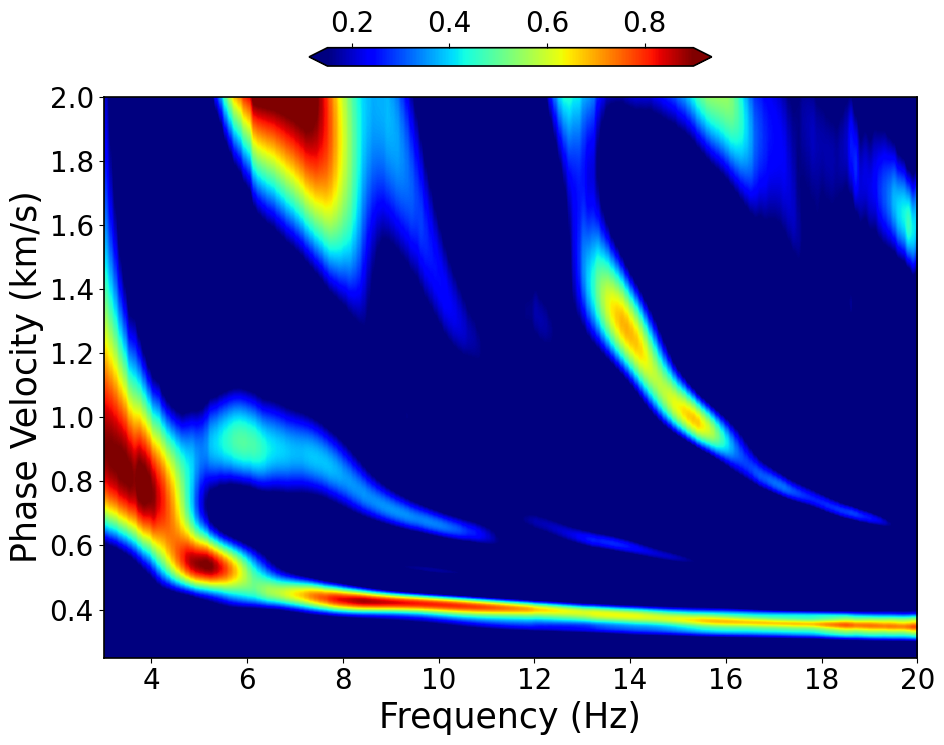

In [86]:
key_subwork = '1--19-09--0.02'
fig = plt.figure(figsize=(10,8))
ax_fj = fig.add_subplot(1,1,1)
plt.style.use('tomo_paper.mplstyle')
name_project_this = name_projects[2]
dir_project_this = dir_project_workspace + name_project_this
filename = dir_project_this+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_ds_this = dir_project_this + info_basic_this['rdir_ds']
c = np.linspace(info_basic_this['fj_c_min'],info_basic_this['fj_c_max'],info_basic_this['fj_c_num'])
ds = h5py.File(dir_ds_this+'ds_'+str(key_subwork)+'.h5', 'r')
ds_remove = ds['ds_remove'][0]
ds_remove = plotlib.smooth_ds(ds_remove,level_c = 20,level_f=12)
f0 = ds['f'][:]
im = ax_fj.imshow(np.flip(ds_remove,0),aspect='auto',extent=[min(f0)-0.5,max(f0)-0.5,min(c),max(c)],vmin=0.15,vmax = 0.9, cmap = 'jet')
ax_fj.set_xlim([3,20])
ax_fj.set_ylim([0.25,2])
ax_fj.set_xticks(np.arange(4,21,2))
ax_fj.set_xlabel('Frequency (Hz)')
ax_fj.set_ylabel('Phase Velocity (km/s)')
fig.colorbar(im, extend = 'both',orientation = 'horizontal',location = 'top', fraction = 0.03, shrink = 0.8, pad = 0.05)
plt.tight_layout()
plt.savefig(dir_image+'thresh_FJ_'+key_subwork+'.eps')

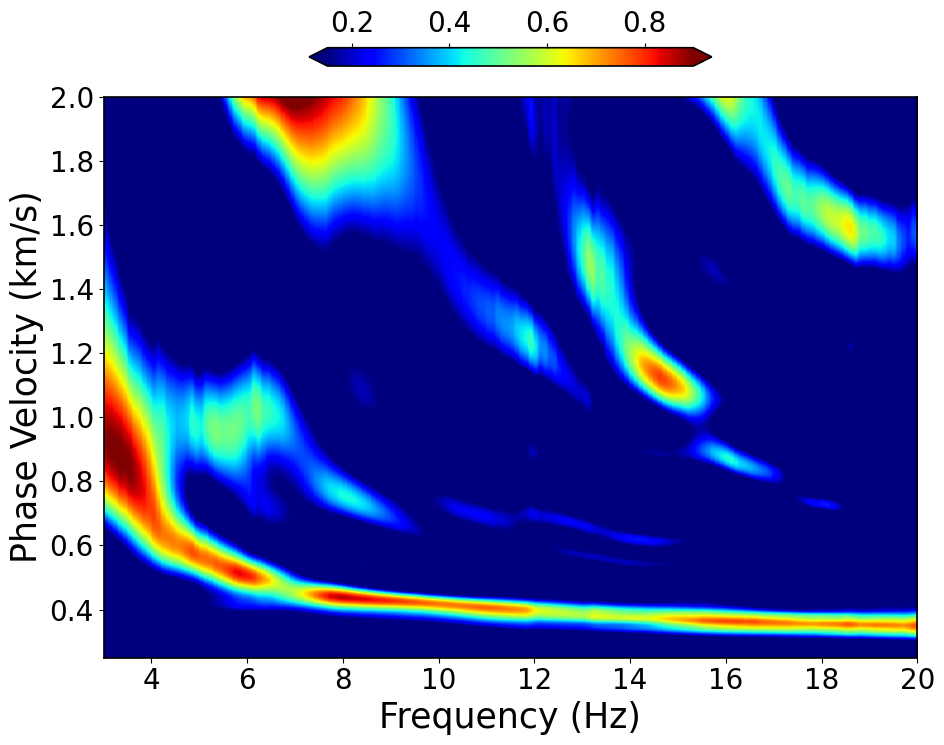

In [87]:
key_subwork = '1--19-09--0.05'
fig = plt.figure(figsize=(10,8))
ax_fj = fig.add_subplot(1,1,1)
plt.style.use('tomo_paper.mplstyle')
name_project_this = name_projects[2]
dir_project_this = dir_project_workspace + name_project_this
filename = dir_project_this+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_ds_this = dir_project_this + info_basic_this['rdir_ds']
c = np.linspace(info_basic_this['fj_c_min'],info_basic_this['fj_c_max'],info_basic_this['fj_c_num'])
ds = h5py.File(dir_ds_this+'ds_'+str(key_subwork)+'.h5', 'r')
ds_remove = ds['ds_remove'][0]
ds_remove = plotlib.smooth_ds(ds_remove,level_c = 20,level_f=12)
f0 = ds['f'][:]
im = ax_fj.imshow(np.flip(ds_remove,0),aspect='auto',extent=[min(f0)-0.5,max(f0)-0.5,min(c),max(c)],vmin=0.15,vmax = 0.9, cmap = 'jet')
ax_fj.set_xlim([3,20])
ax_fj.set_ylim([0.25,2])
ax_fj.set_xticks(np.arange(4,21,2))
ax_fj.set_xlabel('Frequency (Hz)')
ax_fj.set_ylabel('Phase Velocity (km/s)')
fig.colorbar(im, extend = 'both',orientation = 'horizontal',location = 'top', fraction = 0.03, shrink = 0.8, pad = 0.05)
plt.tight_layout()
plt.savefig(dir_image+'thresh_FJ_'+key_subwork+'.eps')

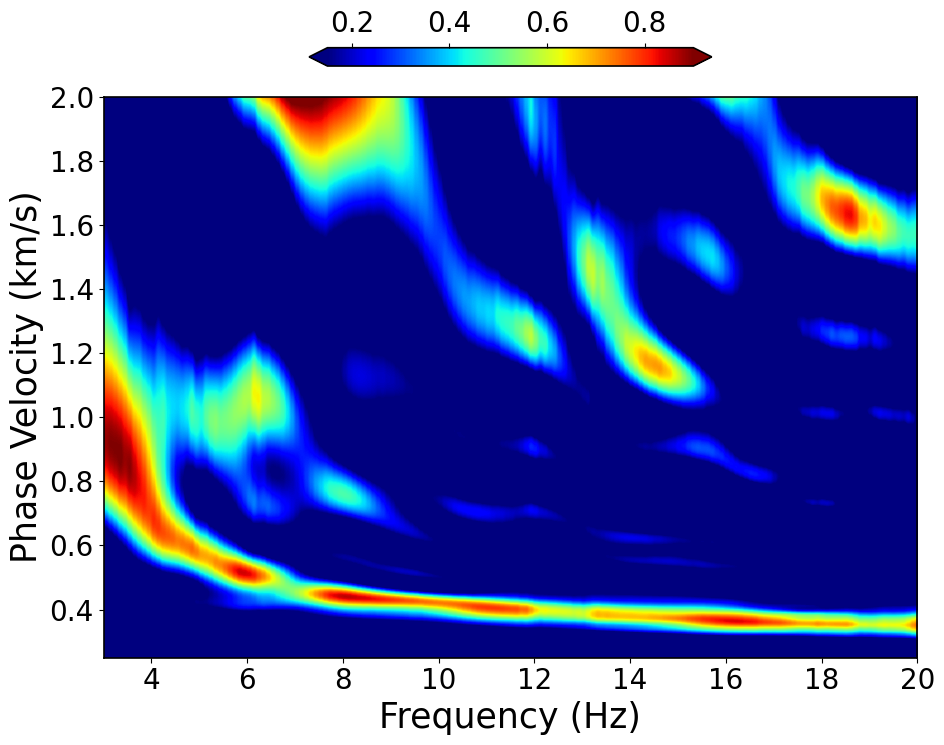

In [93]:
key_subwork = '1--19-09--0.08'
fig = plt.figure(figsize=(10,8))
ax_fj = fig.add_subplot(1,1,1)
plt.style.use('tomo_paper.mplstyle')
name_project_this = name_projects[2]
dir_project_this = dir_project_workspace + name_project_this
filename = dir_project_this+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_ds_this = dir_project_this + info_basic_this['rdir_ds']
c = np.linspace(info_basic_this['fj_c_min'],info_basic_this['fj_c_max'],info_basic_this['fj_c_num'])
ds = h5py.File(dir_ds_this+'ds_'+str(key_subwork)+'.h5', 'r')
ds_remove = ds['ds_remove'][0]
ds_remove = plotlib.smooth_ds(ds_remove,level_c = 20,level_f=12)
f0 = ds['f'][:]
im = ax_fj.imshow(np.flip(ds_remove,0),aspect='auto',extent=[min(f0)-0.5,max(f0)-0.5,min(c),max(c)],vmin=0.15,vmax = 0.9, cmap = 'jet')
ax_fj.set_xlim([3,20])
ax_fj.set_ylim([0.25,2])
ax_fj.set_xticks(np.arange(4,21,2))
ax_fj.set_xlabel('Frequency (Hz)')
ax_fj.set_ylabel('Phase Velocity (km/s)')
fig.colorbar(im, extend = 'both',orientation = 'horizontal',location = 'top', fraction = 0.03, shrink = 0.8, pad = 0.05)
plt.tight_layout()
plt.savefig(dir_image+'thresh_FJ_'+key_subwork+'.eps')

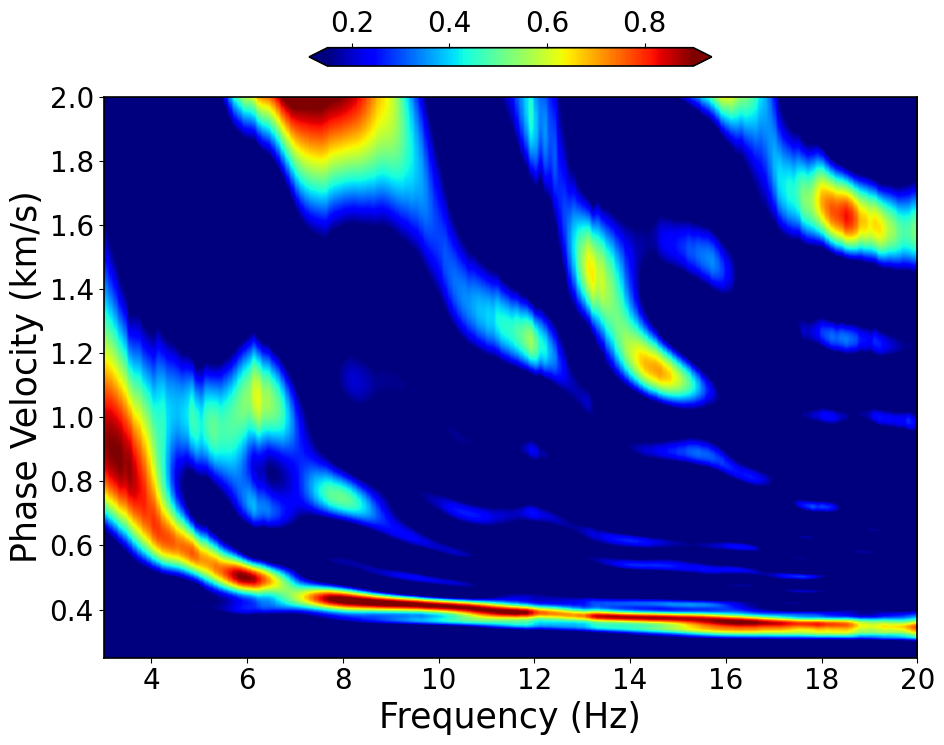

In [88]:
key_subwork = '1--19-09--1'
fig = plt.figure(figsize=(10,8))
ax_fj = fig.add_subplot(1,1,1)
plt.style.use('tomo_paper.mplstyle')
name_project_this = name_projects[2]
dir_project_this = dir_project_workspace + name_project_this
filename = dir_project_this+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_ds_this = dir_project_this + info_basic_this['rdir_ds']
c = np.linspace(info_basic_this['fj_c_min'],info_basic_this['fj_c_max'],info_basic_this['fj_c_num'])
ds = h5py.File(dir_ds_this+'ds_'+str(key_subwork)+'.h5', 'r')
ds_remove = ds['ds_remove'][0]
ds_remove = plotlib.smooth_ds(ds_remove,level_c = 10,level_f=12)
f0 = ds['f'][:]
im = ax_fj.imshow(np.flip(ds_remove,0),aspect='auto',extent=[min(f0)-0.5,max(f0)-0.5,min(c),max(c)],vmin=0.15,vmax = 0.9, cmap = 'jet')
ax_fj.set_xlim([3,20])
ax_fj.set_ylim([0.25,2])
ax_fj.set_xticks(np.arange(4,21,2))
ax_fj.set_xlabel('Frequency (Hz)')
ax_fj.set_ylabel('Phase Velocity (km/s)')
fig.colorbar(im, extend = 'both',orientation = 'horizontal',location = 'top', fraction = 0.03, shrink = 0.8, pad = 0.05)
plt.tight_layout()
plt.savefig(dir_image+'thresh_FJ_'+key_subwork+'.eps')

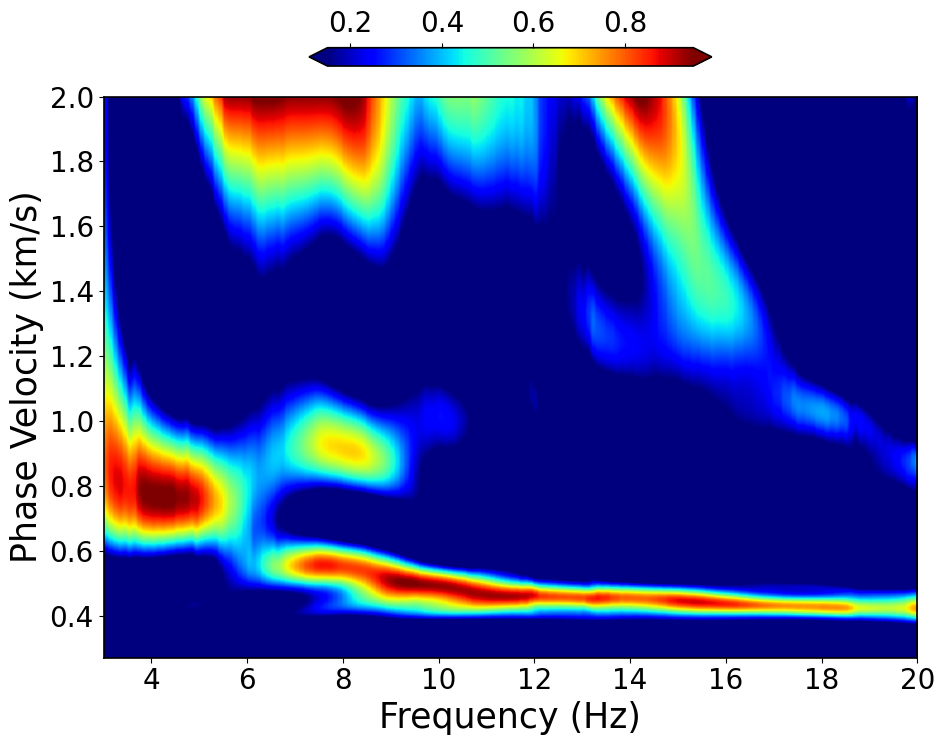

In [89]:
key_subwork = '1--16-03--0.04'
fig = plt.figure(figsize=(10,8))
ax_fj = fig.add_subplot(1,1,1)
plt.style.use('tomo_paper.mplstyle')
name_project_this = name_projects[3]
dir_project_this = dir_project_workspace + name_project_this
filename = dir_project_this+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_ds_this = dir_project_this + info_basic_this['rdir_ds']
c = np.linspace(info_basic_this['fj_c_min'],info_basic_this['fj_c_max'],info_basic_this['fj_c_num'])
ds = h5py.File(dir_ds_this+'ds_'+str(key_subwork)+'.h5', 'r')
ds_remove = ds['ds_remove'][0]
ds_remove = plotlib.smooth_ds(ds_remove,level_c = 20,level_f=12)
f0 = ds['f'][:]
im = ax_fj.imshow(np.flip(ds_remove,0),aspect='auto',extent=[min(f0)-0.5,max(f0)-0.5,min(c),max(c)],vmin=0.15,vmax = 0.95, cmap = 'jet')
ax_fj.set_xlim([3,20])
ax_fj.set_ylim([0.27,2])
ax_fj.set_xticks(np.arange(4,21,2))
ax_fj.set_xlabel('Frequency (Hz)')
ax_fj.set_ylabel('Phase Velocity (km/s)')
fig.colorbar(im, extend = 'both',orientation = 'horizontal',location = 'top', fraction = 0.03, shrink = 0.8, pad = 0.05)
plt.tight_layout()
plt.savefig(dir_image+'thresh_FJ_'+key_subwork+'.eps')

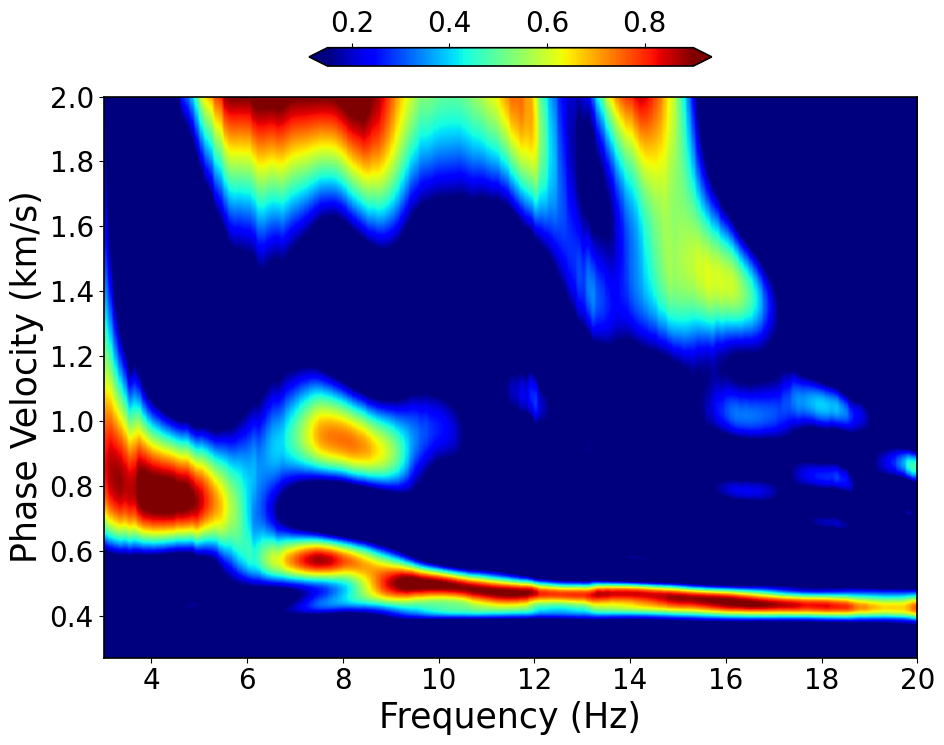

In [90]:
key_subwork = '1--16-03--0.05'
fig = plt.figure(figsize=(10,8))
ax_fj = fig.add_subplot(1,1,1)
plt.style.use('tomo_paper.mplstyle')
name_project_this = name_projects[3]
dir_project_this = dir_project_workspace + name_project_this
filename = dir_project_this+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_ds_this = dir_project_this + info_basic_this['rdir_ds']
c = np.linspace(info_basic_this['fj_c_min'],info_basic_this['fj_c_max'],info_basic_this['fj_c_num'])
ds = h5py.File(dir_ds_this+'ds_'+str(key_subwork)+'.h5', 'r')
ds_remove = ds['ds_remove'][0]
ds_remove = plotlib.smooth_ds(ds_remove,level_c = 20,level_f=12)
f0 = ds['f'][:]
im = ax_fj.imshow(np.flip(ds_remove,0),aspect='auto',extent=[min(f0)-0.5,max(f0)-0.5,min(c),max(c)],vmin=0.15,vmax = 0.9, cmap = 'jet')
ax_fj.set_xlim([3,20])
ax_fj.set_ylim([0.27,2])
ax_fj.set_xticks(np.arange(4,21,2))
ax_fj.set_xlabel('Frequency (Hz)')
ax_fj.set_ylabel('Phase Velocity (km/s)')
fig.colorbar(im, extend = 'both',orientation = 'horizontal',location = 'top', fraction = 0.03, shrink = 0.95, pad = 0.05)
plt.tight_layout()
plt.savefig(dir_image+'thresh_FJ_'+key_subwork+'.eps')

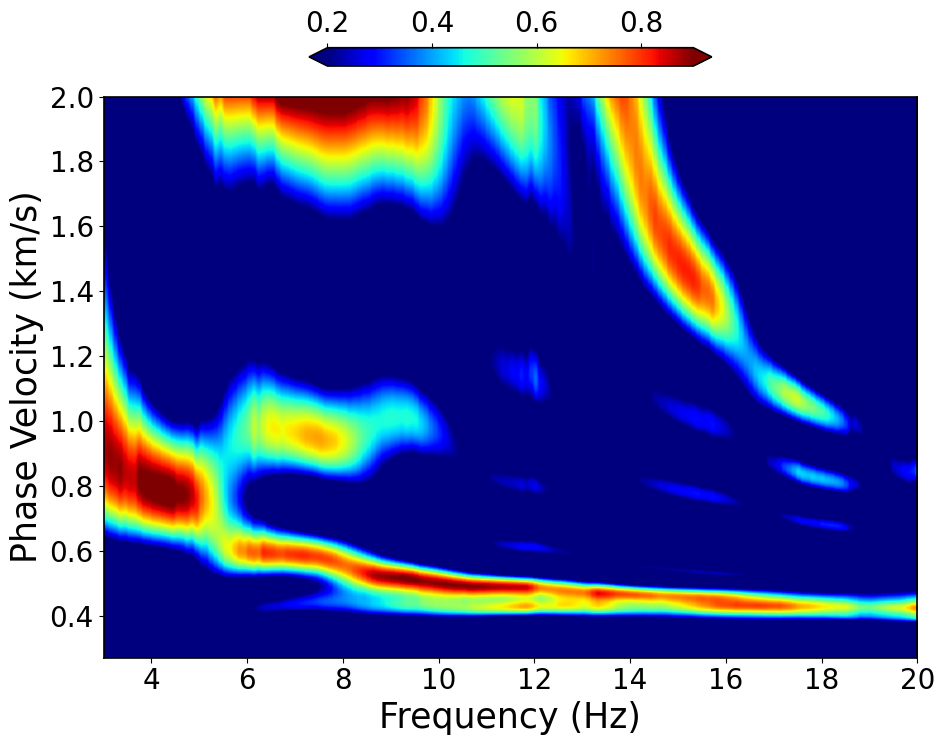

In [91]:
key_subwork = '1--16-03--0.08'
fig = plt.figure(figsize=(10,8))
ax_fj = fig.add_subplot(1,1,1)
plt.style.use('tomo_paper.mplstyle')
name_project_this = name_projects[3]
dir_project_this = dir_project_workspace + name_project_this
filename = dir_project_this+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_ds_this = dir_project_this + info_basic_this['rdir_ds']
c = np.linspace(info_basic_this['fj_c_min'],info_basic_this['fj_c_max'],info_basic_this['fj_c_num'])
ds = h5py.File(dir_ds_this+'ds_'+str(key_subwork)+'.h5', 'r')
ds_remove = ds['ds_remove'][0]
ds_remove = plotlib.smooth_ds(ds_remove,level_c = 20,level_f=12)
f0 = ds['f'][:]
im = ax_fj.imshow(np.flip(ds_remove,0),aspect='auto',extent=[min(f0)-0.5,max(f0)-0.5,min(c),max(c)],vmin=0.2,vmax = 0.9, cmap = 'jet')
ax_fj.set_xlim([3,20])
ax_fj.set_ylim([0.27,2])
ax_fj.set_xticks(np.arange(4,21,2))
ax_fj.set_xlabel('Frequency (Hz)')
ax_fj.set_ylabel('Phase Velocity (km/s)')
fig.colorbar(im, extend = 'both',orientation = 'horizontal',location = 'top', fraction = 0.03, shrink = 0.95, pad = 0.05)
plt.tight_layout()
plt.savefig(dir_image+'thresh_FJ_'+key_subwork+'.eps')

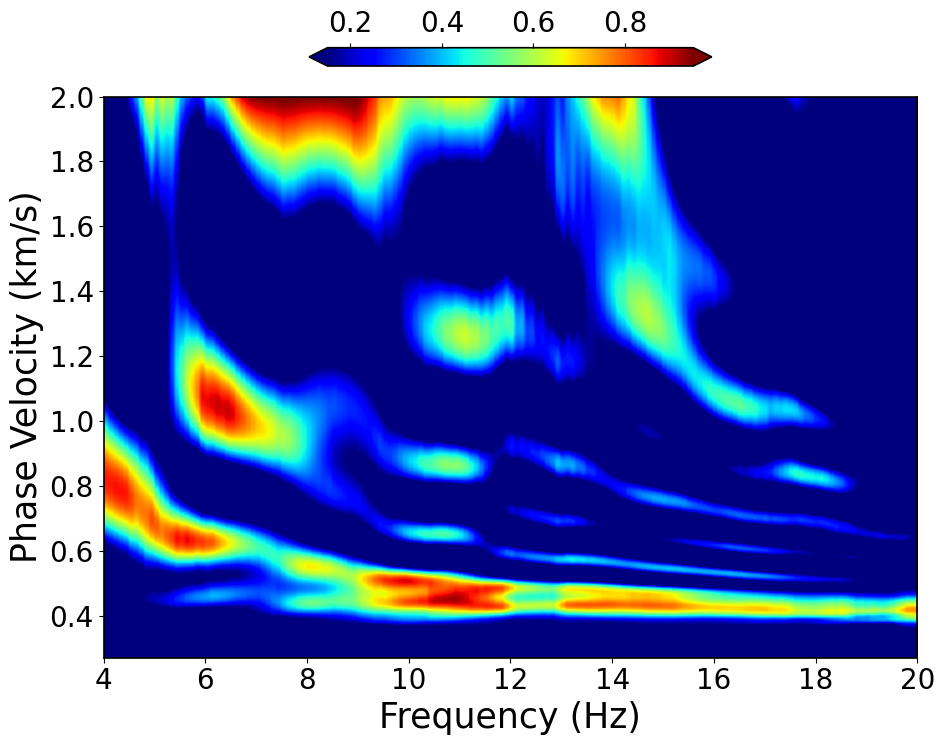

In [92]:
key_subwork = '1--16-03--1'
fig = plt.figure(figsize=(10,8))
ax_fj = fig.add_subplot(1,1,1)
plt.style.use('tomo_paper.mplstyle')
name_project_this = name_projects[3]
dir_project_this = dir_project_workspace + name_project_this
filename = dir_project_this+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_ds_this = dir_project_this + info_basic_this['rdir_ds']
c = np.linspace(info_basic_this['fj_c_min'],info_basic_this['fj_c_max'],info_basic_this['fj_c_num'])
ds = h5py.File(dir_ds_this+'ds_'+str(key_subwork)+'.h5', 'r')
ds_remove = ds['ds_remove'][0]
ds_remove = plotlib.smooth_ds(ds_remove,level_c = 18,level_f=10)
f0 = ds['f'][:]
im = ax_fj.imshow(np.flip(ds_remove,0),aspect='auto',extent=[min(f0)-0.5,max(f0)-0.5,min(c),max(c)],vmin=0.15,vmax = 0.95, cmap = 'jet')
ax_fj.set_xlim([4,20])
ax_fj.set_ylim([0.27,2])
ax_fj.set_xticks(np.arange(4,21,2))
ax_fj.set_xlabel('Frequency (Hz)')
ax_fj.set_ylabel('Phase Velocity (km/s)')
fig.colorbar(im, extend = 'both',orientation = 'horizontal',location = 'top', fraction = 0.03, shrink = 0.95, pad = 0.05)
plt.tight_layout()
plt.savefig(dir_image+'thresh_FJ_'+key_subwork+'.eps')